In [5]:
from qiskit import QuantumCircuit, IBMQ, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
import qiskit.tools.jupyter
from qiskit.visualization import plot_histogram, plot_gate_map, plot_circuit_layout
from qiskit.tools.monitor import job_monitor
#%qiskit_version_table
#%qiskit_copyright
import numpy as np
from time import gmtime, strftime, localtime
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

service = QiskitRuntimeService(channel="ibm_cloud", token="Bc6LgcOInZ_fhruj9JOe9D3rJQQCJ4nP2_P5zaEqgzpe", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/546fb41a6c4445218104ba4fcad6d4b4:4bccfdf9-1193-407a-9e5b-bd5c2620b6f3::")

# Mapping the old layout to the qubits of the IBM machine

g0=0
g1=1
g2=2
g3=3
g4=4
g5=5
g6=6
g7=7
g8=8
g9=9
g10=10
g11=11
g12=12
#g13=13
g14=13
#g15=15
g16=14
g17=15
g18=16
g19=17

#g20=2
#g21=21
#g22=22
#g23=23
#g24=24
#g25=25
#g26=26

G=[g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g14,g16,g17,g18,g19]

# Set the measurement you want to either 'charge' or 'flux' or 'both'.
measurement_type = 'both'

# Set the initial state to 'identity', 'ground state' or 'random'

initial_state = 'ground state'

# Set whether or not a ribbon is applied (True/False)

ribbon = True

# Initialize Qubits
circ = QuantumCircuit(18, 18)


if initial_state == 'ground state':
# Prepare groundstate

    circ.h(g0)
    circ.h(g1)
    circ.h(g2)
    circ.h(g9)
    circ.h(g10)
    circ.h(g11)


    circ.cx(g0,g3)
    circ.cx(g1,g4)
    circ.cx(g2,g5)
    circ.cx(g9,g6)
    circ.cx(g10,g7)
    circ.cx(g11,g8)

    
if ribbon:
  ## Ribbon 1 up to the 'crossover swap'
    print('test')
    circ.h(g16)                        # create Bell pair
    circ.cx(g16,g17)
    #circ.swap(g0,g1)                   # Swap qubits representing R2 and m on edge 1
    circ.cx(g0,g17)                    # Conjugate ancilla
    circ.cx(g2,g0)                     # Start the multiplication onto the edge
    circ.cx(g1,g0)                     # Swap back and CNOT m onto R2, 4 CNOTs simplify to 2
    #circ.cx(g0,g1)
    circ.cx(g17,g1)                    # CNOT from ancilla and complete the multiplication onto edge 1
    circ.x(g2)

    #circ.swap(g17,g20)                 # Move ancilla to edge 4, swap R2 and R on edge 4
    #circ.swap(g17,g21)
    #circ.swap(g7,g8)

    circ.cx(g17,g7)                    # CNOT from ancilla onto edge 4
    #circ.swap(g7,g8)
    circ.cx(g8,g7)
    circ.x(g7)                         # The two X gates complete the postmultiplication of edge 4 by the ancilla inverse
    circ.x(g8)
    
    
## Ribbon 2 up to the 'crossover swap'
    circ.h(g18)                         # create Bell pair
    circ.cx(g18,g19)                      
    #circ.swap(g9,g6)                    # SWAPs for conjugation by edge 6
    circ.cx(g9,g19)                     # conjugation
    #circ.swap(g9,g6)

    
     # The crossover circ.swap

    #circ.swap(g17,g19)                     # circ.swaps the position of the two ribbon ancillas

      # Completing ribbon 1
    circ.cx(g6,g17)                      # circ.cx from edge four, the m qubit, onto the ancilla for conjugation


      # Completing ribbon 2
    #circ.swap(g19,g22)
    circ.cx(g8,g7)
    circ.cx(g19,g7)
    circ.x(g8)

                     

      # Moving both ancilla pairs back together, undoing bell pair state and measure

    #circ.swap(g16,g20)
    #circ.swap(g22,g19)
    #circ.swap(g16,g21)
   # circ.swap(g19,g17)
    circ.cx(g16,g17)
    circ.cx(g18,g19)
    circ.h(g16)
    circ.h(g18)
    
    
        
if measurement_type == 'both':
    print('both')
    circ.h(g12)
    circ.h(g14)        # Set up superposition of subgroup {e,m,R2,mR2}. Qubit 12 encodes m, qubit 14 encodes R2.

  #  circ.cx(g12,g13)         # Multiply onto neighbouring ancillas
  #  circ.cx(g14,g15)

    circ.cx(g12,g6)          # Multiply into the edges 3 and 4 that make up a plaquette, acting on the m and R2 qubits.
    circ.cx(g12,g9)
    circ.cx(g14,g7)
    circ.cx(g14,g10)

#    circ.cx(g12,g13)         # Undo multiplication onto the additional ancillas
#    circ.cx(g14,g15)

    circ.h(g12)  ##strategy=InsertStrategy.NEW_THEN_INLINE)        # Hadamard back
    circ.h(g14)
   
    if ribbon:
        measuredbits=12             
        circ.measure(G[6:12] + [g12,g14]+G[14:18],range(measuredbits)) 
    else:
        measuredbits=8             
        circ.measure(G[6:12] + [g12,g14],range(measuredbits))
        
        

        
        
from qiskit.providers.fake_provider import FakeMumbai

        
local_layout=[15,18,21, 16,19,22, 4, 10,7, 5,11,8,3,14,13,12,0,1] 
backend = FakeMumbai()
sim = AerSimulator.from_backend(backend)


min = 100
print(strftime("%Y-%m-%d %H:%M:%S", localtime()))

# Transpile the circuit for the noisy basis gates
for i in range(1000):
    ttest = transpile(circ, sim, initial_layout=local_layout,optimization_level=3)
    testmin=ttest.depth()
    if testmin< min:
        min=testmin
        tcirc=ttest
        print(min)   
print(strftime("%Y-%m-%d %H:%M:%S", localtime()))
print(tcirc.depth())


test
both
2022-09-30 14:24:09
66
58
51
50
2022-09-30 14:26:58
50


In [15]:

with Sampler(circuits=[tcirc], service=service, options={ "backend": "" }, skip_transpilation=True) as sampler:
    result = sampler(circuits=[0],shots=100000)
    print(result)


SamplerResult(quasi_dists=[{'000000000000000000': 0.00109, '000000000000000001': 0.00025, '000000000000010000': 0.0008, '000000000100000000': 0.00119, '000000000100000001': 0.00016, '000000000100000010': 0.00107, '000000000100000011': 0.00034, '000000000100000100': 4e-05, '000000000100000101': 1e-05, '000000000100000110': 4e-05, '000000000100000111': 1e-05, '000000000100001000': 0.00025, '000000000100001001': 0.00107, '000000000100001010': 0.00022, '000000000100001011': 0.00091, '000000000100001100': 4e-05, '000000000100001101': 8e-05, '000000000100001110': 1e-05, '000000000100001111': 4e-05, '000000000000010001': 0.00019, '000000000100010000': 0.00078, '000000000100010001': 0.00019, '000000000100010010': 0.00088, '000000000100010011': 0.00028, '000000000100010100': 3e-05, '000000000100010110': 6e-05, '000000000100010111': 1e-05, '000000000100011000': 0.00022, '000000000100011001': 0.00068, '000000000100011010': 0.00018, '000000000100011011': 0.00064, '000000000100011101': 5e-05, '0000

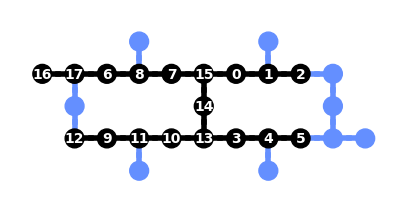

In [12]:
tcirc.depth()
plot_circuit_layout(tcirc,backend)        